In [37]:
##########################Load Libraries  ####################################
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt


import random 

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torchinfo import summary
import pandas as pd
import os

from tqdm import trange
import inspect
import time
import itertools

%matplotlib inline
%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


My utils


In [38]:
from myUtils import *

Plotting utils


In [39]:
from plottingUtils import *

Data utils


In [40]:
from dataUtils import *

In [41]:
# hyperparameters

data_dir = ".\datasets\PJM_power"
fname = "COMED_hourly.csv"

sample_len = 120
step = 1
target_len = 48
batch_size = 64
steps_in_day = 24

HID_DIM = 64
RNN_LAYERS = 4
LIN_LAYERS = 2
DROPOUT = 0.5
N_SIN_TERMS = 16
N_PARAMS = 2 + 3 * N_SIN_TERMS

learning_rate = 1e-3
epochs = 100

In [42]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
print(torch.__version__)

Using cuda device
2.0.1+cu117


In [43]:
def apply_vals(vals, seq):
    """
    vals: [batch size, n_features, n_params]

    """
    # n params = 2 + 3*n sin terms
    batch_size = vals.shape[0]
    n_features = vals.shape[1]
    vals = vals.unsqueeze(3)
    # vals = [batch size, n_features, n_params, 1]

    seq = seq.unsqueeze(0).unsqueeze(1).repeat(batch_size, n_features, 1).float()
    # seq = [batch size, n_features, len seq]

    x = vals[:, :, 3::3] + torch.matmul(vals[:, :, 4::3], seq.unsqueeze(2))
    # x = [batch size, n_features, n sin terms, len seq]
    # vals[:,:, 3::3] = [batch size, n_features, n sin terms, 1]
    # print("x", x.shape, x.device)
    # print("a", vals[:,:,2::3].shape)
    out = vals[:, :, 0] + vals[:, :, 1] * seq + (vals[:, :, 2::3] * torch.sin(x)).sum(2)
    # out = [batch size, n_features, len seq]
    # print("out", out.shape, out.device)
    return out.permute(0, 2, 1).contiguous()


def print_params(params, feature):
    l = params[0, feature].tolist()
    output = f"Feature {feature}: {l[0]:6.3f} + {l[1]:6.3f} * x\n"
    print("params:", feature, params.shape)
    
    terms = [f"+ {l[3*i+2]:6.3f}*sin({l[3*i+3]:6.3f} + {l[3*i+4]:6.3f}*x)\n" for i in range(len(l) // 3)]
    output += "".join(terms)
    print(output)


def make_predictions(model, samples, len, device):
    with torch.no_grad():
        print("samples:", samples.shape)
        values = model(samples.to(device))
        [print_params(values, i) for i in range(samples.shape[2])]
        output = apply_vals(values, torch.arange(len).to(device))
    return output

In [44]:
class Fourier(nn.Module):
    def __init__(
        self,
        n_features,
        n_params,
        device,
        hid_dim=64,
        rnn_layers=2,
        lin_layers=1,
        dropout=0.5,
    ):
        super().__init__()

        self.hid_dim = hid_dim
        self.n_layers = rnn_layers
        self.device = device

        self.rnn = nn.GRU(
            input_size=n_features,
            hidden_size=hid_dim,
            num_layers=rnn_layers,
            dropout=dropout,
            batch_first=True,
        )

        # create fc
        self.fc = nn.Sequential()
        for i in range(lin_layers):
            self.fc.add_module(
                f"lin{i}", nn.Linear(hid_dim * rnn_layers, hid_dim * rnn_layers)
            )
            self.fc.add_module(f"relu{i}", nn.LeakyReLU())
        self.fc.add_module(
            f"lin{lin_layers}", nn.Linear(hid_dim * rnn_layers, n_params * n_features)
        )

    def forward(self, src):
        # src = [batch size, src len, n features]

        batch_size = src.shape[0]
        n_features = src.shape[2]

        _, hidden = self.rnn(src)

        # hidden = [n layers, batch size, hid dim]
        hidden = hidden.permute(1, 0, 2).reshape(batch_size, -1).contiguous()
        # hidden = [batch size, n layers * hid dim]
        output = self.fc(hidden)
        # output = [batch size, n params * n features]
        return output.reshape(batch_size, n_features, -1)

In [45]:
def train(
    dataloader,
    model,
    loss_fn,
    optimizer,
    iter_count=None,
    visibility=True,
):
    """
    dataloader: iterable
    model: model to train
    loss_fn: loss function
    optimizer: used optimizer
    iter_count: number of iterations, if None then dataloader length
    teacher_forcing_ratio: probability to use teacher forcing
    visibility: boolean, if True then show progress bar
    """
    assert not (
        inspect.isgenerator(dataloader) and iter_count is None
    ), "generator must have specified size"
    if iter_count is None:
        iter_count = len(dataloader.dataset)

    data_iterator = iter(dataloader)
    model.train()
    average_loss = 0

    r = trange(iter_count) if visibility else range(iter_count)

    for _ in r:
        x, y = next(data_iterator)
        x, y = x.to(device), y.to(device)
        # Compute prediction error

        pred = model(x)
        value = apply_vals(pred, torch.arange(y.shape[1]).to(device))

        loss = loss_fn(value, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        average_loss += loss.item()

    average_loss /= iter_count

    return average_loss


In [46]:
def eval(dataloader, model, loss_fn, iter_count=None, visibility=True):
    """
    dataloader: iterable
    model: model to train
    loss_fn: loss function
    iter_count: number of iterations, if None then dataloader length
    visibility: boolean, if True then show progress bar
    """
    if iter_count is None:
        iter_count = len(dataloader.dataset)
    data_iterator = iter(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        r = trange(iter_count) if visibility else range(iter_count)
        for _ in r:
            x, y = next(data_iterator)
            x, y = x.to(device), y.to(device)

            pred = model(x)
            value = apply_vals(pred, torch.arange(y.shape[1]).to(device))

            test_loss += loss_fn(value, y).item()

    test_loss /= iter_count

    return test_loss


In [47]:
def fit_model(
    model,
    train_dataloader,
    val_dataloader,
    loss_fn,
    optimizer,
    scheduler,
    epochs=5,
    train_iter_count=None,
    val_iter_count=None,
    visibility=0,
    save_model=False,
):
    """
    model: model to train
    train_dataloader: iterable
    val_dataloader: iterable
    loss_fn: loss function
    optimizer: used optimizer
    scheduler: used scheduler
    epochs: number of epochs
    train_iter_count: number of training iterations
    val_iter_count: number of validation iterations
    teacher_forcing_ratio: probability to use teacher forcing
    visibility: 0 - no progress bar, 1 - progress bar for entire training, 2 - progress bar for each epoch
    save_model: boolean, if True then save model with lowest validation loss
    """
    history = {
        "train": {"loss": []},
        "val": {"loss": []},
    }
    total_time_start = time.time()
    r = trange(epochs) if visibility == 1 else range(epochs)

    min_val_loss = np.inf

    for t in r:
        if visibility == 2:
            print(f"Epoch {t+1}\n-------------------------------")
            print("Test")
        train_loss = train(
            train_dataloader,
            model,
            loss_fn=loss_fn,
            optimizer=optimizer,
            iter_count=train_iter_count,
            visibility=(visibility == 2),
        )
        if visibility == 2:
            print("Eval")
        val_loss = eval(
            val_dataloader,
            model,
            loss_fn=loss_fn,
            iter_count=val_iter_count,
            visibility=(visibility == 2),
        )

        scheduler.step(val_loss)

        if min_val_loss > val_loss and save_model:
            min_val_loss = val_loss
            torch.save(model, "model.pth")
        if visibility == 2:
            print(f"Train Error: Avg loss: {train_loss:.4f} ")
            print(f"Validation Error: Avg loss: {val_loss:.4f} \n")
        if visibility == 1:
            r.set_postfix({"Avg": f"{val_loss:.4f}", "Min": f"{min_val_loss:.4f}"})
        history["train"]["loss"].append(train_loss)
        history["val"]["loss"].append(val_loss)

    total_time_end = time.time()
    total_duration = total_time_end - total_time_start

    average_duration = total_duration / epochs
    if visibility != 0:
        print(f"Total Duration: {print_duration(total_duration)}")
        print(f"Average Duration: {print_duration(average_duration)}")
        print(f"Min Validation Loss: {min_val_loss:.4f}")

    return history

In [48]:
def run_fit_model(
    data,
    device,
    sample_len=120,
    target_len=24,
    step=1,
    batch_size=64,
    HID_DIM=64,
    RNN_LAYERS=4,
    LIN_LAYERS=2,
    DROPOUT=0.5,
    N_SIN_TERMS=16,
    learning_rate=1e-3,
    epochs=100,
    verbose=False,
):
    # hyperparameters
    N_FEATURES = data.shape[1]
    N_PARAMS = 2 + 3 * N_SIN_TERMS
    # generators
    train_generator, val_generator = get_dataset_generators(
        data,
        sample_len,
        target_len,
        step,
        batch_size,
        shuffle=True,
    )

    if verbose:
        # print a sample
        samples, targets = next(train_generator)
        for feature in range(samples.shape[-1]):
            plot_samples(samples, targets, feature, figsize=(15, 1))

    # instantiate model

    N_FEATURES = data.shape[1]

    model = Fourier(
        n_features=N_FEATURES,
        n_params=N_PARAMS,
        device=device,
        hid_dim=HID_DIM,
        rnn_layers=RNN_LAYERS,
        lin_layers=LIN_LAYERS,
        dropout=DROPOUT,
    ).to(device)
    
    if verbose:
        # print model
        print(model)
        print(
            summary(
                model,
                input_size=(10, sample_len, N_FEATURES),
                col_names=[
                    "input_size",
                    "output_size",
                    "num_params",
                    "trainable",
                    "kernel_size",
                ],
                col_width=15,
            )
        )
    # Fit model

    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, factor=0.1, patience=10
    )
    
    history = fit_model(
        model,
        train_dataloader=train_generator,
        train_iter_count=200,
        val_dataloader=val_generator,
        val_iter_count=100,
        loss_fn=loss_fn,
        optimizer=optimizer,
        scheduler=scheduler,
        epochs=epochs,
        save_model=True,
        visibility=(1 if verbose else 0),
    )
    if verbose:
        plot_history(history)
    # get min loss
    best_model = torch.load("model.pth")
    return best_model, history

In [49]:
def evaluate_parameters(
    data,
    device,
    num_runs_per_config=1,
    sample_len_list = [sample_len],
    target_len_list = [target_len],
    step_list = [step],
    batch_size_list = [batch_size],
    hiddim_list = [HID_DIM],
    rnn_layers_list = [RNN_LAYERS],
    lin_layers_list = [LIN_LAYERS],
    dropout_list = [DROPOUT],
    n_sin_terms_list = [N_SIN_TERMS],
    learning_rate_list = [learning_rate],
    epochs_list = [epochs],
):
    configurations = list(itertools.product(
        sample_len_list,
        target_len_list,
        step_list,
        batch_size_list,
        hiddim_list,
        rnn_layers_list,
        lin_layers_list,
        dropout_list,
        n_sin_terms_list,
        learning_rate_list,
        epochs_list,
    ))

    for configuration in configurations:
        sample_len, target_len, step, batch_size, hid_dim, rnn_layers, lin_layers, dropout, n_sin_terms, learning_rate, epochs = configuration
        

        print("Sample length:", sample_len, "Target length:", target_len, "Step size", step, "Batch size", batch_size)
        print("HID dim:", hid_dim, "RNN layers:", rnn_layers, "Lin layers:", lin_layers, "Dropout:", dropout)
        print("N sin terms:", n_sin_terms, "Learning rate:", learning_rate, "Epochs:", epochs)
        min_val_loss = np.inf
        for _ in trange(num_runs_per_config):
            
            
            _, history = run_fit_model(
                data,
                device,
                sample_len,
                target_len,
                step,
                batch_size,
                hid_dim,
                rnn_layers,
                lin_layers,
                dropout,
                n_sin_terms,
                learning_rate,
                epochs,
                verbose=False,
            )
            min_val_loss = min(min(history["val"]["loss"]), min_val_loss)
        
        print("______ Min validation loss:", round(min_val_loss,5))
        print("__________________________________________________")


In [50]:
# preprocessing

df = extract_dataframe(data_dir, fname)
# df = add_features(df, steps_in_day=steps_in_day)

header, float_data = extract_data(df)
data, mean, std = normalize_data(float_data)

In [51]:
#evaluate_parameters(data, device, 
#                    num_runs_per_config=1, 
#                    hiddim_list=[64], 
#                    sample_len_list=[120, 240, 360], 
#                    target_len_list=[24, 48, 96], 
#                    n_sin_terms_list=[16],)

Sample length: 120 Target length: 24 Step size 1 Batch size 64
HID dim: 64 RNN layers: 4 Lin layers: 2 Dropout: 0.5
N sin terms: 16 Learning rate: 0.001 Epochs: 100


100%|██████████| 1/1 [03:28<00:00, 208.22s/it]


______ Min validation loss: 0.11451
__________________________________________________
Sample length: 120 Target length: 48 Step size 1 Batch size 64
HID dim: 64 RNN layers: 4 Lin layers: 2 Dropout: 0.5
N sin terms: 16 Learning rate: 0.001 Epochs: 100


100%|██████████| 1/1 [03:26<00:00, 206.75s/it]


______ Min validation loss: 0.21744
__________________________________________________
Sample length: 120 Target length: 96 Step size 1 Batch size 64
HID dim: 64 RNN layers: 4 Lin layers: 2 Dropout: 0.5
N sin terms: 16 Learning rate: 0.001 Epochs: 100


100%|██████████| 1/1 [03:45<00:00, 225.48s/it]


______ Min validation loss: 0.32875
__________________________________________________
Sample length: 240 Target length: 24 Step size 1 Batch size 64
HID dim: 64 RNN layers: 4 Lin layers: 2 Dropout: 0.5
N sin terms: 16 Learning rate: 0.001 Epochs: 100


100%|██████████| 1/1 [05:32<00:00, 332.44s/it]


______ Min validation loss: 0.10702
__________________________________________________
Sample length: 240 Target length: 48 Step size 1 Batch size 64
HID dim: 64 RNN layers: 4 Lin layers: 2 Dropout: 0.5
N sin terms: 16 Learning rate: 0.001 Epochs: 100


100%|██████████| 1/1 [05:40<00:00, 340.06s/it]


______ Min validation loss: 0.2158
__________________________________________________
Sample length: 240 Target length: 96 Step size 1 Batch size 64
HID dim: 64 RNN layers: 4 Lin layers: 2 Dropout: 0.5
N sin terms: 16 Learning rate: 0.001 Epochs: 100


100%|██████████| 1/1 [05:45<00:00, 345.17s/it]


______ Min validation loss: 0.35685
__________________________________________________
Sample length: 360 Target length: 24 Step size 1 Batch size 64
HID dim: 64 RNN layers: 4 Lin layers: 2 Dropout: 0.5
N sin terms: 16 Learning rate: 0.001 Epochs: 100


100%|██████████| 1/1 [06:53<00:00, 413.81s/it]


______ Min validation loss: 0.10076
__________________________________________________
Sample length: 360 Target length: 48 Step size 1 Batch size 64
HID dim: 64 RNN layers: 4 Lin layers: 2 Dropout: 0.5
N sin terms: 16 Learning rate: 0.001 Epochs: 100


100%|██████████| 1/1 [07:13<00:00, 433.94s/it]


______ Min validation loss: 0.21695
__________________________________________________
Sample length: 360 Target length: 96 Step size 1 Batch size 64
HID dim: 64 RNN layers: 4 Lin layers: 2 Dropout: 0.5
N sin terms: 16 Learning rate: 0.001 Epochs: 100


100%|██████████| 1/1 [07:14<00:00, 434.97s/it]

______ Min validation loss: 0.34553
__________________________________________________


In [52]:
def run_make_predictions(model, data, device, num_preds=5, sample_len=sample_len, target_len=target_len, step=step, batch_size=batch_size):
    _, val_generator = get_dataset_generators(
        data,
        sample_len,
        target_len,
        step,
        batch_size,
        shuffle=True,
    )
    
    for _ in range(num_preds):
        samples, targets = next(val_generator)
        output = make_predictions(model, samples, targets.shape[1], device)
        plot_predictions(header, samples, targets, output, mean, std)

In [53]:
t = 24
assert False
model, history = run_fit_model(data, device, verbose=True, learning_rate=1e-3, target_len=t, N_SIN_TERMS=10, sample_len=120, HID_DIM=64, epochs=100)
min_val_loss = min(history["val"]["loss"])
print(min_val_loss)



    

AssertionError: 

samples: torch.Size([64, 120, 1])
params: 0 torch.Size([64, 1, 32])
Feature 0:  0.500 + -0.009 * x
+ -0.179*sin(-1.428 +  0.174*x)
+ -0.042*sin( 0.227 + -0.144*x)
+  0.633*sin(-0.522 +  0.289*x)
+  0.015*sin(-0.803 +  0.184*x)
+ -0.305*sin( 1.692 + -0.347*x)
+  0.052*sin(-0.233 +  0.003*x)
+  0.152*sin( 2.451 + -0.544*x)
+  0.148*sin( 1.517 + -0.169*x)
+  0.071*sin( 1.227 + -0.154*x)
+  0.007*sin( 0.906 + -0.048*x)

COMED_MW


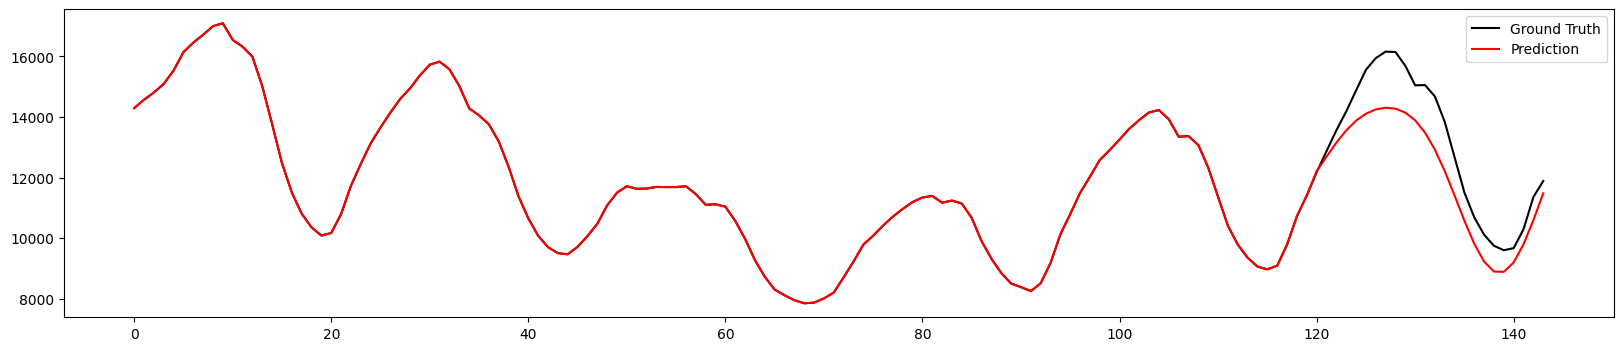

samples: torch.Size([64, 120, 1])
params: 0 torch.Size([64, 1, 32])
Feature 0:  0.691 +  0.004 * x
+ -0.027*sin(-1.383 +  0.124*x)
+ -0.193*sin( 0.187 + -0.242*x)
+  0.962*sin(-0.651 +  0.256*x)
+  0.177*sin(-0.737 +  0.232*x)
+ -0.197*sin( 1.028 + -0.368*x)
+  0.054*sin(-0.291 +  0.039*x)
+  0.272*sin( 2.255 + -0.467*x)
+ -0.164*sin( 1.394 + -0.202*x)
+  0.008*sin( 1.279 + -0.104*x)
+ -0.071*sin( 0.778 + -0.130*x)

COMED_MW


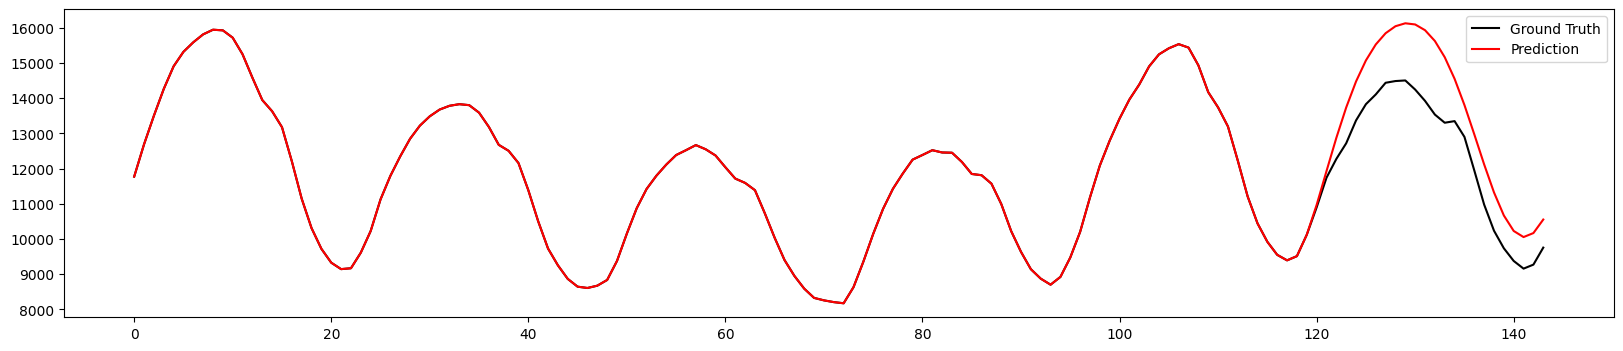

samples: torch.Size([64, 120, 1])
params: 0 torch.Size([64, 1, 32])
Feature 0: -0.542 + -0.011 * x
+ -0.070*sin(-1.113 +  0.283*x)
+  0.037*sin( 0.950 + -0.264*x)
+  0.070*sin(-1.071 +  0.250*x)
+ -0.225*sin( 0.044 +  0.207*x)
+  0.007*sin( 0.614 + -0.561*x)
+  0.053*sin( 0.141 +  0.014*x)
+  0.225*sin( 1.813 + -0.487*x)
+  0.096*sin( 1.078 + -0.239*x)
+  0.072*sin( 0.681 + -0.013*x)
+ -0.069*sin( 1.147 +  0.018*x)

COMED_MW


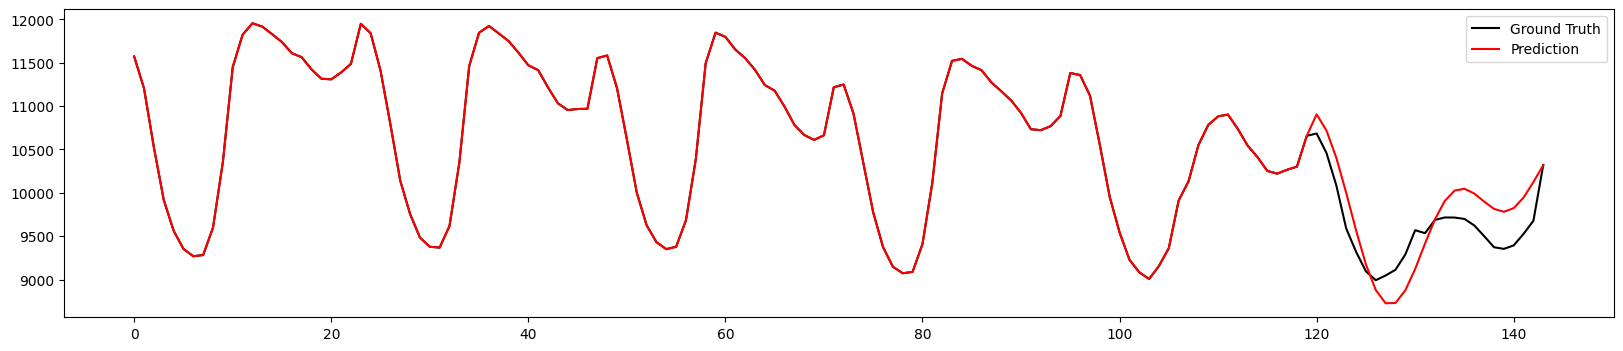

samples: torch.Size([64, 120, 1])
params: 0 torch.Size([64, 1, 32])
Feature 0: -0.440 +  0.002 * x
+ -0.092*sin(-1.066 +  0.303*x)
+  0.002*sin( 0.918 + -0.198*x)
+  0.051*sin(-0.821 +  0.261*x)
+ -0.191*sin(-0.047 +  0.219*x)
+ -0.116*sin( 0.455 + -0.611*x)
+  0.018*sin( 0.092 + -0.072*x)
+  0.229*sin( 1.790 + -0.435*x)
+  0.243*sin( 1.009 + -0.291*x)
+  0.026*sin( 0.594 + -0.213*x)
+ -0.053*sin( 1.098 +  0.006*x)

COMED_MW


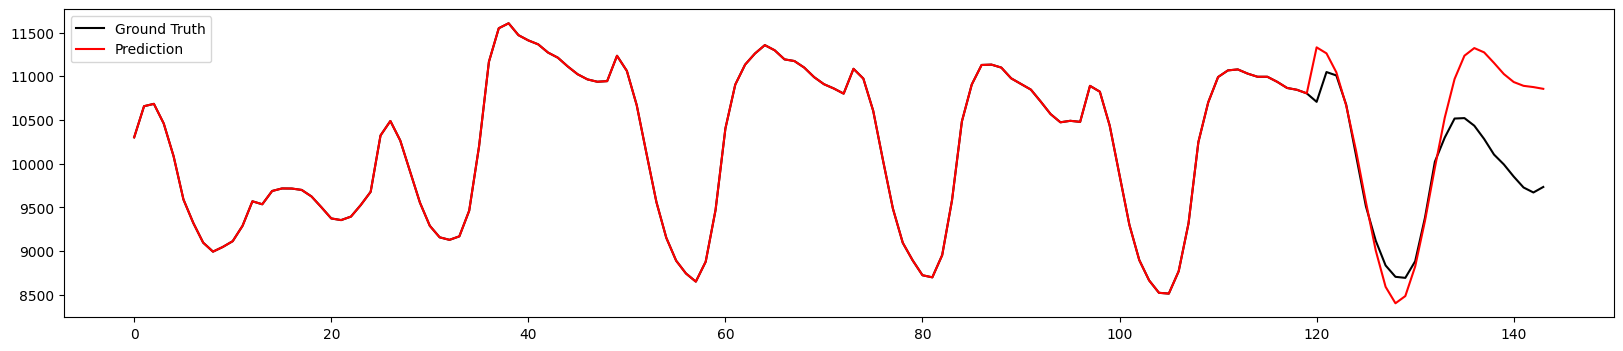

samples: torch.Size([64, 120, 1])
params: 0 torch.Size([64, 1, 32])
Feature 0: -0.080 + -0.012 * x
+ -0.136*sin(-1.364 +  0.185*x)
+  0.036*sin( 0.760 + -0.044*x)
+  0.233*sin(-0.812 +  0.346*x)
+ -0.098*sin(-0.438 +  0.182*x)
+ -0.319*sin( 3.044 + -0.537*x)
+  0.007*sin( 0.095 + -0.022*x)
+  0.025*sin( 1.655 + -0.501*x)
+  0.141*sin( 1.513 + -0.269*x)
+  0.068*sin( 1.030 + -0.155*x)
+ -0.037*sin( 0.945 + -0.050*x)

COMED_MW


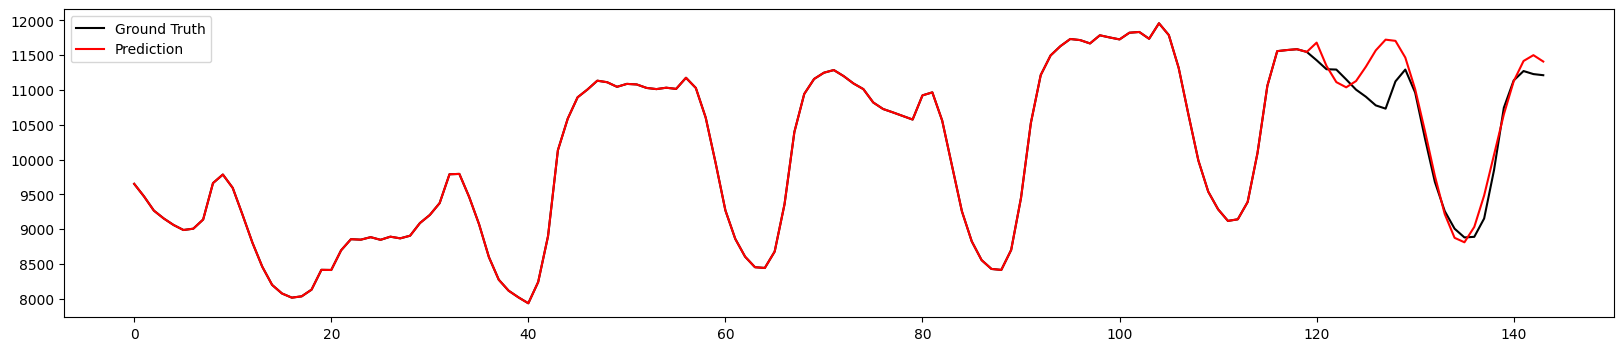

In [ ]:
run_make_predictions(model, data, device, target_len=t)